In [211]:
#stuff

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Purpose of this Notebook

In [212]:
#Number of reviews to put into data frame of good reviews
NUMB_OF_DOCS1 = 1000

#Number of reviews to put into data frame of bad reviews
NUMB_OF_DOCS2=100

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Problem Statement

Product developers often want to know this about their products:

* For products that people don't like, what is it about the products they don't like? Maybe if we know this we could improve the product by fixing this unliked product features
* For products that people love, what is it about the products that result in people loving them? Maybe if we expanded on these loved features, we could get new customers or better retain current customers

## Proposed Solution

Topic modeling and clustering(?) that identifies the features of products that people love and somehow rank them so that a product manaer can have a priority list of things that could be addressed to get more love
Topic modeling and clustering(?) that identifies the features of products that people don't like and somehow rank them so that a product manaer can have a priority list of things that could be fixed to hopefully turn the disliked product into a liked product.


# Module Import

In [312]:
import datetime
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



import re

#to speed up pandas operands
from pandarallel import pandarallel

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import pyLDAvis
import pyLDAvis.sklearn

#gensim
from gensim import corpora, models, similarities, matutils



/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# NLP Pipeline



## Text Preprocessing
Essentially will do this:

```

(input text) -->[clean(remove text I don't want)]--> [tokenization] --> [lemmatization] --> [Next_Stages]

```

In [214]:
reviews_df = pd.read_csv("../Data/Reviews.csv")

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [215]:
reviews_df.head()

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [242]:
reviews_df.describe()

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [253]:
reviews_df.loc[0,"Text"]

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [243]:
reviews_df["Score"].value_counts()

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [244]:
reviews_df["helpful_rating"] = reviews_df["HelpfulnessNumerator"] / reviews_df["HelpfulnessDenominator"]

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


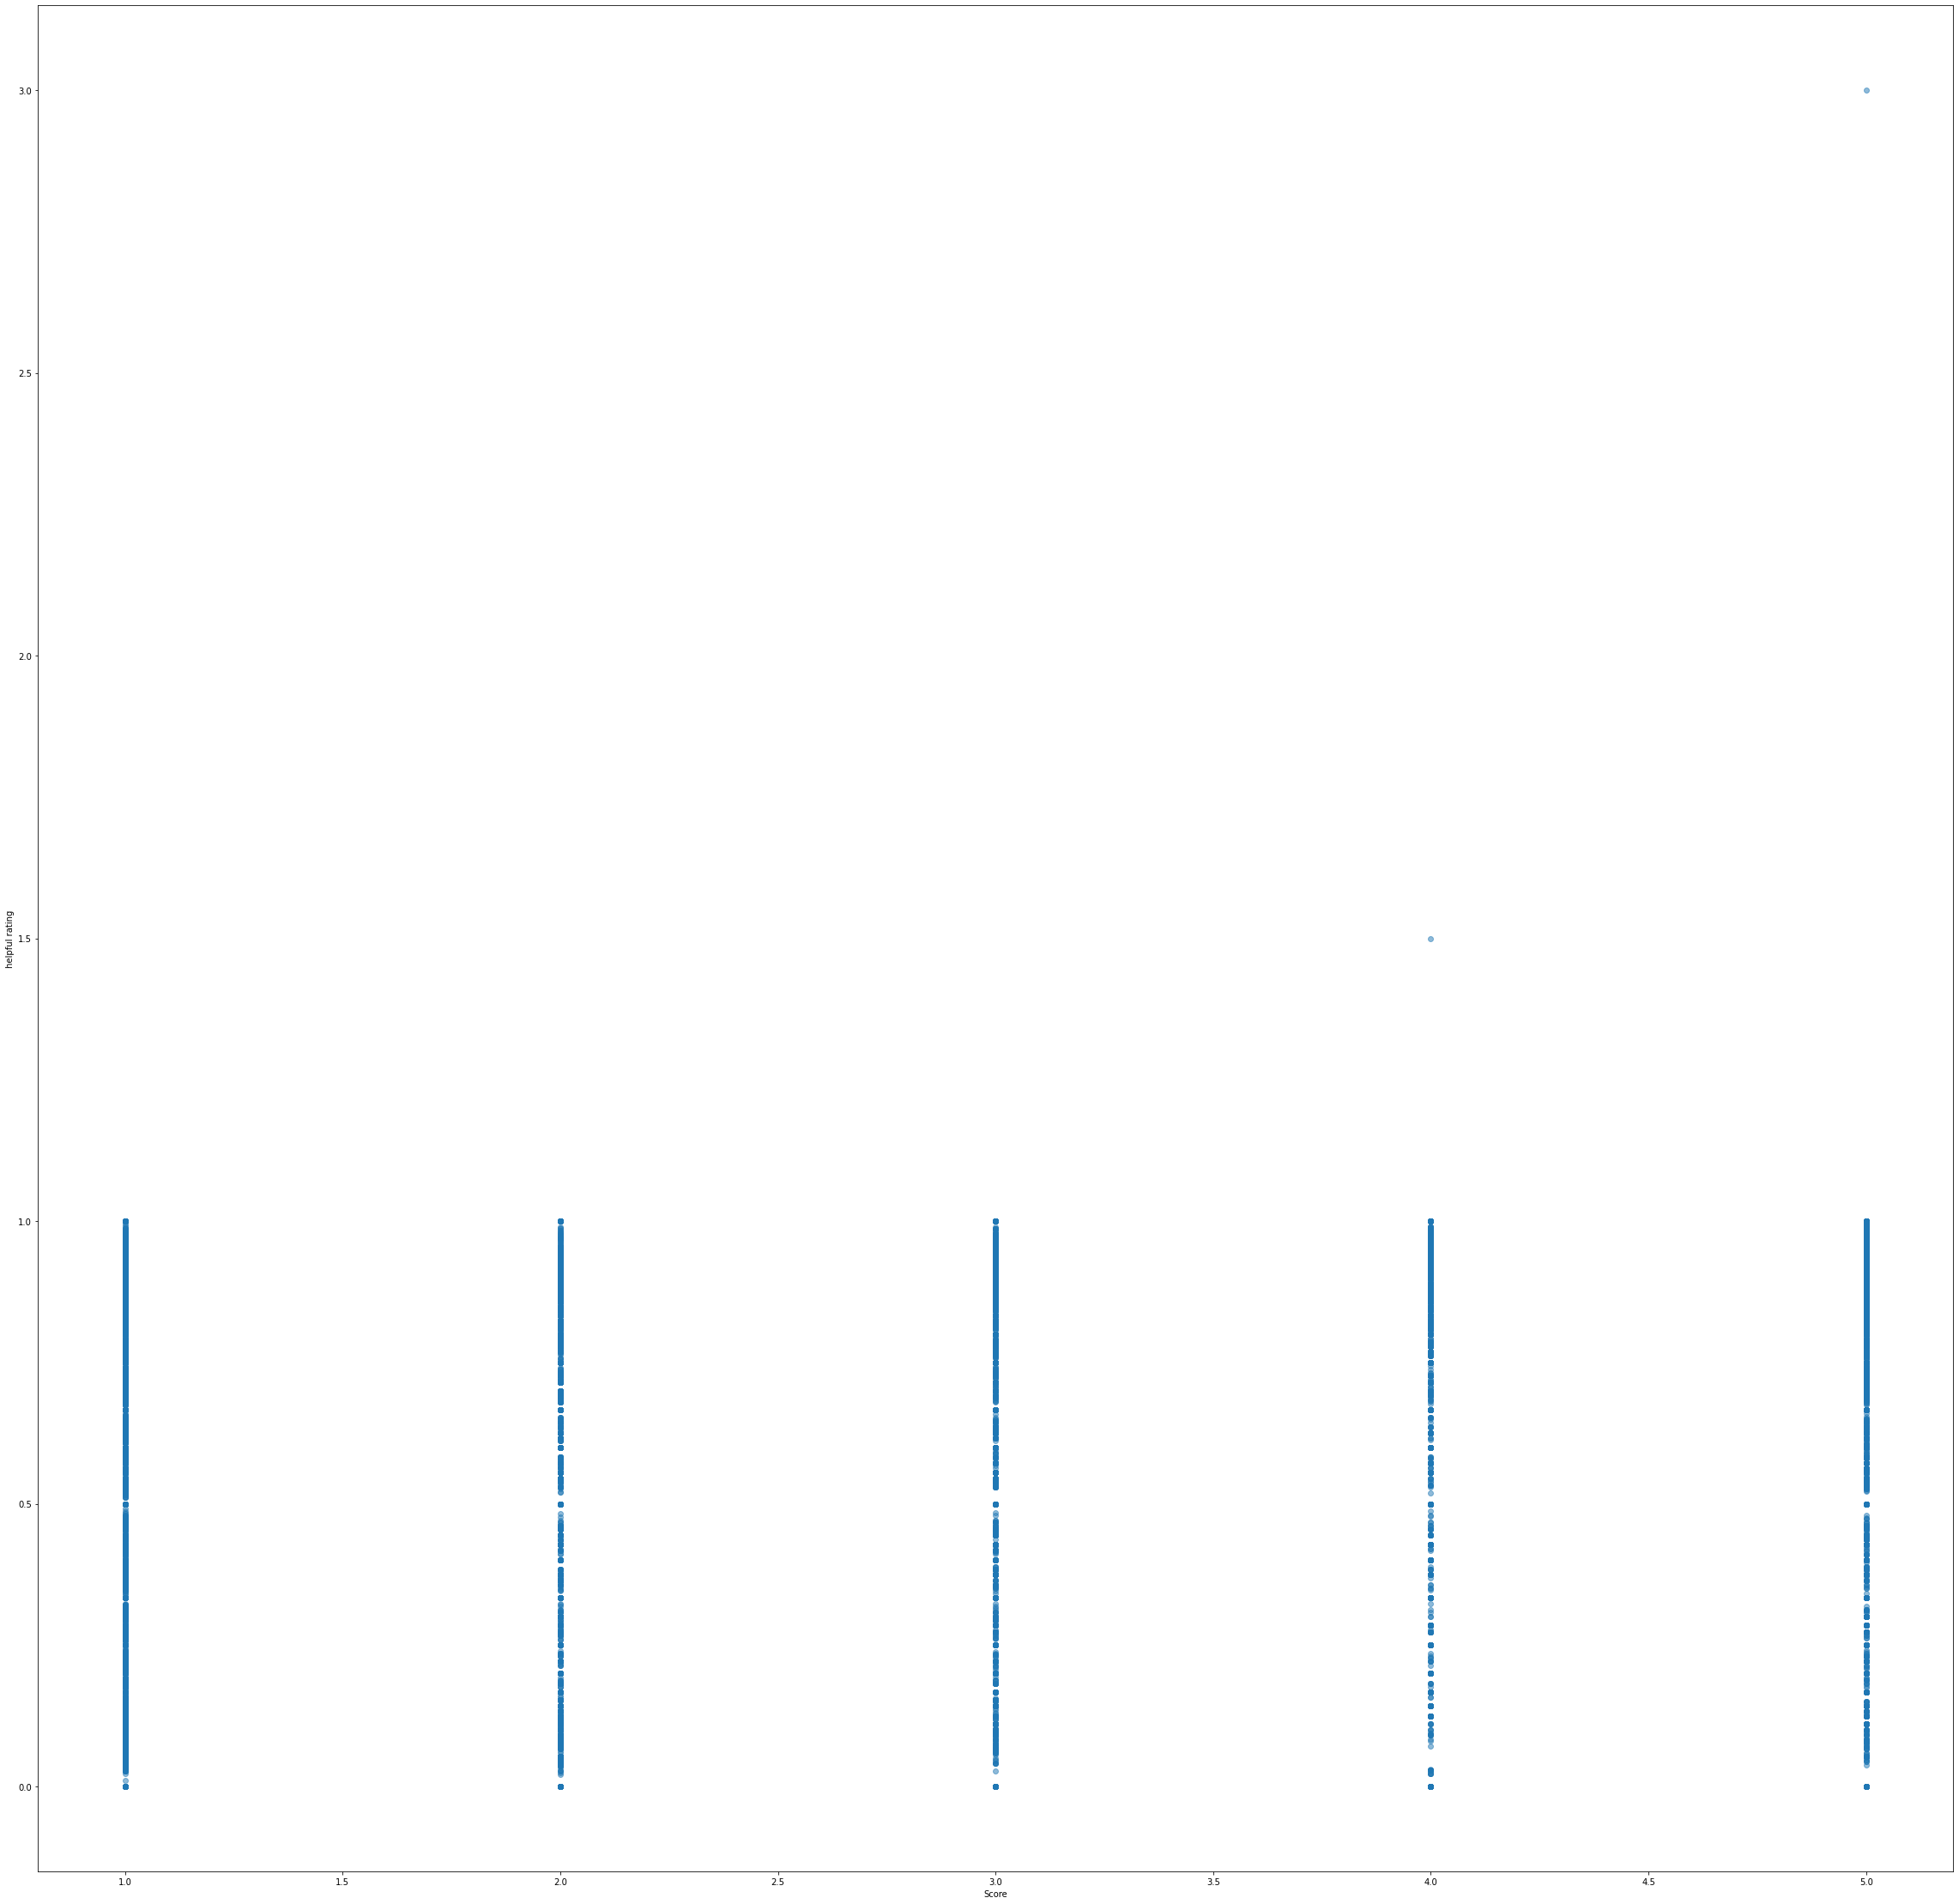

In [246]:
plt.figure(figsize=(40,40))
plt.scatter(reviews_df["Score"],reviews_df["helpful_rating"],alpha=0.5)
plt.xlabel("Score")
plt.ylabel("helpful rating")
plt.show();

Going to create a dataframe of bad reviews and one of good reviews to process separately

In [216]:
good_reviews_df = reviews_df[ reviews_df["Score"] >= 4 ]
bad_reviews_df = reviews_df[ reviews_df["Score"] <= 2 ]

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [217]:
if (NUMB_OF_DOCS1 > good_reviews_df.shape[0]) or (NUMB_OF_DOCS1 < 0):
    NUMB_OF_DOCS1 = good_reviews_df.shape[0]


if (NUMB_OF_DOCS2 > bad_reviews_df.shape[0]) or (NUMB_OF_DOCS2 < 0):
    NUMB_OF_DOCS2 = bad_reviews_df.shape[0]

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [218]:
stuff =list(good_reviews_df.Text.head(NUMB_OF_DOCS1))

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [219]:
#Removing HTML from the text
stuff = [re.sub("<.*?>","",item) for item in stuff]

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [220]:
#remove punctuation
stuff = [  re.sub("[\.|\!|\?|\,|\;|\:|\&|\(|\)|\-]","",mystring) for mystring in stuff  ]

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:2: DeprecationWarning: invalid escape sequence \.
<>:2: DeprecationWarning: invalid escape sequence \.
<ipython-input-220-3fbbec9803b4>:2: DeprecationWarning: invalid escape sequence \.
  stuff = [  re.sub("[\.|\!|\?|\,|\;|\:|\&|\(|\)|\-]","",mystring) for mystring in stuff  ]


**Tokenize**

In [221]:
stuff_tokenized= []

stuff_tokenized = [word_tokenize(review) for review in stuff]

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [222]:
#stuff_tokenized[1]

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [223]:
#for i,item in enumerate(stuff_tokenized):
#    if i == 10:
#        break
#    print(i,"-->",item,"\n")

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [275]:
#lemmatize each word in stuff
def calc_partofspeech(raw_pos):
    """translates from POS generated by pos_tag() to a POS encoding that WordNetLemmatizer.lemmatize() understands"""
    #print("word = ",word)
    #[(output_word, output_pos)] = pos_tag(word_tokenize(word))
    
    #decode output_pos to the pos required by the lemmatizer
    
    if "JJ" in raw_pos:
        pos = "a"
    elif "RB" in raw_pos:
        pos = "r"
    elif "VB" in raw_pos:
        pos = "v"
    else:
        pos = "n"
    
    return pos




/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [225]:
#for i,item in enumerate(stuff):
#   if i == 10:
#        break
#   print(i,"-->",item,"\n")

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [274]:
stuff_tokenized[0]

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['I',
 'have',
 'bought',
 'several',
 'of',
 'the',
 'Vitality',
 'canned',
 'dog',
 'food',
 'products',
 'and',
 'have',
 'found',
 'them',
 'all',
 'to',
 'be',
 'of',
 'good',
 'quality',
 'The',
 'product',
 'looks',
 'more',
 'like',
 'a',
 'stew',
 'than',
 'a',
 'processed',
 'meat',
 'and',
 'it',
 'smells',
 'better',
 'My',
 'Labrador',
 'is',
 'finicky',
 'and',
 'she',
 'appreciates',
 'this',
 'product',
 'better',
 'than',
 'most']

lemmatizing to cut down on the size of the dimensions of the eventual vectorized word matrix without losing meaning of the text

In [277]:
wordNetLemmatizer = WordNetLemmatizer()

stuff_lemmatized = []

for mydoc in stuff_tokenized:
    #temp_mydoc = " ".join(mydoc)
    temp_mydoc_lemmatized = []
    
    pos_result = pos_tag(mydoc)
    
    for myword,mypos in pos_result:

        temp_word_lemmatized = wordNetLemmatizer.lemmatize(myword,calc_partofspeech(mypos))
        temp_mydoc_lemmatized.append(temp_word_lemmatized)

    stuff_lemmatized.append(temp_mydoc_lemmatized)
    
#stuff_lemmatized = [wordNetLemmatizer.lemmatize(myword,calc_partofspeech(myword)) for mydoc in stuff_tokenized for myword in mydoc]



/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [227]:
#Test code doesn't need to be run
#myword = "running"
#myword_lemmed = wordNetLemmatizer.lemmatize(myword,calc_partofspeech(myword))
#myword_lemmed = wordNetLemmatizer.lemmatize(myword,"v")

#print("myword_lemmed = ",myword_lemmed)
#print("POS for myword = ",calc_partofspeech(myword))

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [279]:
#stuff_lemmatized[0]

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [280]:
# I only want adjectives and adverbs sent to the vectorizer
#stuff_pos_filtered = [mylemword for mylemdoc in stuff_lemmatized for mylemword in mylemdoc if ("JJ" in pos_tag(word_tokenize(mylemword))[0][1]) or ("RB" in pos_tag(word_tokenize(mylemword))[0][1])]

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [281]:
#stuff_pos_filtered[6]

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [294]:
# I only want adjectives and adverbs sent to the vectorizer

def filter_pos(stuff_lemmatized,pos_abbrev=["JJ"]):
    """
    takes as input the following
    list_of_docs = a list(list(str)) object which is a list of documents that have been word tokenized and lemmatized
    pos_abbrev = list of NLTK pos_tag() output parts of speech codes abbreviated to the first two characters
    
    """
#    print("pos_abbrev = ",pos_abbrev)

    stuff_pos_filtered = []
    
    if type(pos_abbrev) != type([]):
        print("post_abbrev must be a list of POS codes (1st 2 char of the code only)")
        return 1

    for mylemdoc in stuff_lemmatized:
    
        temp_pos_filtered_doc = ""
        #pos_tag() works better if you pass the entire document to it as a tokenized list
        #it must be doing some sequence modeling under the hood to get context of words so that it can
        #better ID parts of speech
        
        pos_result = pos_tag(mylemdoc)
    
        for result_word, result_pos in pos_result:
#            print("tokenized word = ", word_tokenize(mylemword))
#            print("tokenized word pos = ", pos_tag(word_tokenize(mylemword))[0][1])
            for mypos in pos_abbrev:
                if (mypos in result_pos) :
                    temp_pos_filtered_doc = temp_pos_filtered_doc + result_word + " "
            
        stuff_pos_filtered.append(temp_pos_filtered_doc.rstrip())
    
    return stuff_pos_filtered


/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [295]:
stuff_pos_filtered = filter_pos(stuff_lemmatized,pos_abbrev=["JJ","RB"])
#stuff_pos_filtered
#stuff_pos_filtered = stuff_pos_filtered + filter_pos(stuff_lemmatized,"RB")

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [296]:
stuff_pos_filtered[0:3]

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['several good more processed smell well finicky good most',
 'few light tiny then liberally powdered tiny Not too chewy very flavorful highly familiar',
 'great wide very quick']

In [297]:
#stuff_lemmatized[0]

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Get the nouns

In [298]:
stuff_nouns = filter_pos(stuff_lemmatized,pos_abbrev=["NN"])

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [302]:
stuff_nouns[0:3]

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['Vitality food product quality product stew meat My Labrador product',
 'confection century pillowy citrus gelatin nut case Filberts square sugar mouthful heaven yummy treat story CS Lewis Lion Witch Wardrobe treat Edmund Brother Sisters Witch',
 'Great taffy price assortment yummy taffy Delivery taffy lover deal']

In [303]:
stuff_pos_filtered[0:5]

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['several good more processed smell well finicky good most',
 'few light tiny then liberally powdered tiny Not too chewy very flavorful highly familiar',
 'great wide very quick',
 'wild very enjoyable many only complaint there too much just not particular last only delightful',
 'great very soft chewy individually wrap well together expensive highly beachthemed']

In [304]:
len(stuff_pos_filtered)

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1000

## Word Vectorization / Parsing

Will do the following here:

```

(lemmatized text)-->[WordVectorization(dropping stop word)] --> [POS tagging] --> [collect Adjectives]


```


In [305]:
vectorizer = CountVectorizer(stop_words="english")
docTermMatrixCountVec = vectorizer.fit_transform(stuff_pos_filtered)

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [306]:
len(vectorizer.get_feature_names())

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1618

In [307]:
docTermMatrixCountVec.toarray()

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [308]:
docTermMatrixCountVec.shape

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1000, 1618)

In [309]:

docTermMatrixCountVec_df = pd.DataFrame(docTermMatrixCountVec.toarray(), index=stuff_pos_filtered, columns=vectorizer.get_feature_names())

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [310]:
docTermMatrixCountVec_df.head()

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,50mile,abate,able,aboutbottomline,absolute,absolutely,abt,acai,acceptable,accessable,...,yeti,yo,youa,young,youngest,yr,yummy,yummybut,zen,zippy
several good more processed smell well finicky good most,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
few light tiny then liberally powdered tiny Not too chewy very flavorful highly familiar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
great wide very quick,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wild very enjoyable many only complaint there too much just not particular last only delightful,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
great very soft chewy individually wrap well together expensive highly beachthemed,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [311]:
LD_Allocator = LatentDirichletAllocation(n_components=5, random_state=0)
LD_Allocator.fit(docTermMatrixCountVec)

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(n_components=5, random_state=0)

## Topics via LDA

## LDA on "Good" Reviews

In [313]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(LD_Allocator, docTermMatrixCountVec, vectorizer)

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.067170  0.037749       1        1  30.240976
4     -0.024527  0.046222       2        1  21.207894
2      0.095607 -0.096120       3        1  20.324050
1     -0.012181  0.081829       4        1  20.112752
0     -0.126069 -0.069681       5        1   8.114328, topic_info=            Term        Freq       Total Category  logprob  loglift
476     favorite   73.000000   73.000000  Default  30.0000  30.0000
577         good  323.000000  323.000000  Default  29.0000  29.0000
1276       small   68.000000   68.000000  Default  28.0000  28.0000
742         just  175.000000  175.000000  Default  27.0000  27.0000
538        fresh   48.000000   48.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
386         easy    3.011399   50.424180   Topic5  -5.2888  -0.3065
1411       tasty    2.539471   46.160541   Topic5  -5.4592  -0.3886
646       highly    2.454744   30.194892   Topic5  -5.4932   0.0019
1149     regular    2.407024   40.202134   Topic5  -5.5128  -0.3040
413   especially    2.320376   26.182098   Topic5  -5.5495   0.0882

[359 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         5  0.653958     50mile
2         1  0.187897       able
2         2  0.046974       able
2         3  0.140923       able
2         4  0.281846       able
...     ...       ...        ...
1585      4  0.634564  wonderful
1596      5  0.888363       wrap
1604      5  0.653958       yeah
1611      2  0.691635      young
1611      4  0.172909      young

[541 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 2, 1])